In [1]:
!pip install -Uqq fastbook

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires mar

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!pip install -Uqq duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.


In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term,max_images=150):
    return L(ddg_images(term,max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('grizzly bear photos',max_images=1)
urls[0]

'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

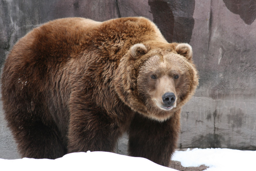

In [6]:
from fastdownload import download_url
dest='bird.jpg'
download_url(urls[0],dest,show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [7]:
import os
searches = 'grizzly','teddy','black'
path = Path('bears')
path.mkdir()


In [8]:
for search in searches:
    dest = path/search
    dest.mkdir(exist_ok=True)
    download_images(dest,urls=search_images(f'{search} bear'))
    resize_images(path/search,max_size=400,dest=path/search)
    
    
        

In [9]:

fns = get_image_files(path)
fns

(#431) [Path('bears/teddy/6316da3c-524a-44dc-bad4-093c95c5e7b3.jpg'),Path('bears/teddy/a9cd89ea-2107-455f-90a2-73a5f9268d6d.jpg'),Path('bears/teddy/bc49bee1-9911-48f5-9ce6-41742861c94e.jpeg'),Path('bears/teddy/95e163bf-9339-4ae6-b11b-c8511ee91e0d.jpg'),Path('bears/teddy/29b39d33-829e-4049-a0aa-2dd777a091bf.jpg'),Path('bears/teddy/b58420be-91c3-4a9f-a38c-66345d5f5165.jpg'),Path('bears/teddy/8d306de2-3601-4c92-a9d5-417a220ba389.jpg'),Path('bears/teddy/149d2e6c-404f-48d2-a967-15b66959c3d7.jpg'),Path('bears/teddy/85147079-eaf0-4742-be4e-6b2e3d571b21.jpg'),Path('bears/teddy/9424b91c-9f72-412c-98ca-e0dbabe3bad6.jpg')...]

In [10]:
failed = verify_images(fns)
failed



(#3) [Path('bears/grizzly/af91707a-540b-45a4-8294-8a90cfec126f.jpg'),Path('bears/grizzly/6d16b860-05d1-4d9b-8193-22236a756e7c.jpg'),Path('bears/grizzly/2e3912ce-1038-4e01-bc1f-ed0c7da3735f.jpg')]

In [11]:
failed.map(Path.unlink);

In [12]:
?verify_images

In [13]:
bears = DataBlock(blocks=(ImageBlock,CategoryBlock),get_items=get_image_files,splitter=RandomSplitter(valid_pct=0.2,seed=31),get_y=parent_label,item_tfms=Resize(128))


In [14]:
type(bears)

fastai.data.block.DataBlock

In [15]:
dls = bears.dataloaders(path)
type(dls)

fastai.data.core.DataLoaders

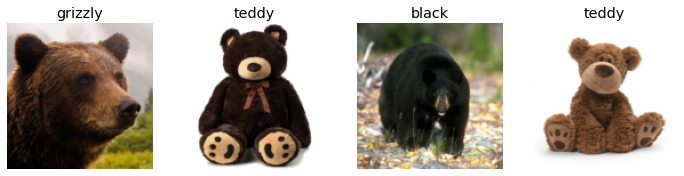

In [16]:
dls.valid.show_batch(max_n=4,nrows=1)

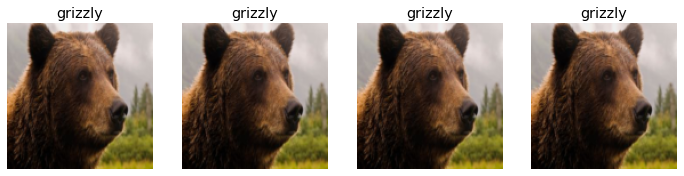

In [17]:
# by default Resize method crops part of the image to fit the size passed to it. -> important details might be missed.
# we could use squish method to resize the full image to fit the size passed -> reolution lost or padding with zeros -> unnecessary computation
# better thing is to do all the above randomly , even rotate the image to make the untrained neural network learn all the above
# part of a process called Data Augmentation
bears = bears.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

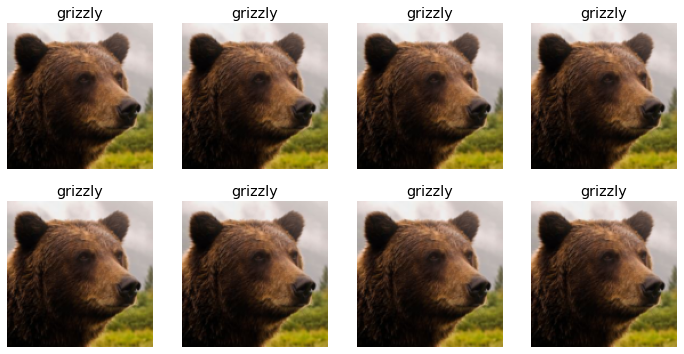

In [18]:
# data augmentation using fastai functions

bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2,unique=True)

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(224,min_scale=0.5),batch_tfms=aug_transforms())
dls = bears.dataloaders(path)


In [20]:
learn = vision_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.322765,0.053994,0.011765,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.252678,0.008196,0.000000,00:03
1,0.169887,0.002136,0.000000,00:03
2,0.124746,0.000802,0.000000,00:03
3,0.099671,0.000822,0.000000,00:02


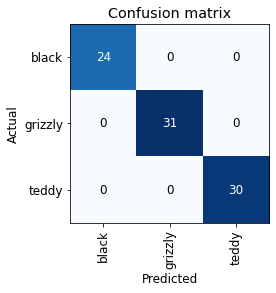

In [21]:
#interpretation of results

intp = ClassificationInterpretation.from_learner(learn)
intp.plot_confusion_matrix()    # computed using the validation loss

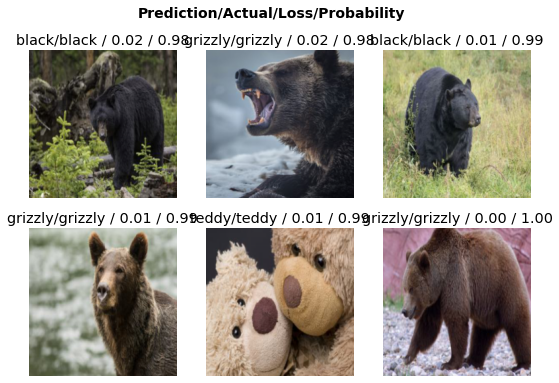

In [22]:
intp.plot_top_losses(6,nrows=2)

In [23]:
#helps clean data -> like fixing the wrong labels labelled by ddg or other search engine
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:

for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
    
for idx in cleaner.change():
    shutil.move(str(cleaner.fns[idx]),path/cat)


In [25]:
bears = bears.new(item_tfms=RandomResizedCrop(224,min_scale=0.5),batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
learn = vision_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(4)


epoch,train_loss,valid_loss,error_rate,time
0,1.355584,0.053724,0.023529,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.152571,0.033593,0.011765,00:03
1,0.116473,0.025764,0.011765,00:02
2,0.082120,0.031717,0.011765,00:02
3,0.069992,0.026850,0.011765,00:02


In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [28]:
# inference of your model

learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('bird.jpg')


('grizzly', TensorBase(1), TensorBase([3.2303e-08, 1.0000e+00, 2.6928e-07]))

In [29]:
learn_inf.dls.vocab   #toget the order of classification categories

['black', 'grizzly', 'teddy']

In [30]:
# make an easily deployable app out of this model in a jupyter notebook
# ipywidgets : provides GUI components to combine the power of jupyter notebook(which is itself a complex web application) and Javascript modules
# voila :  helps convert the complex web application(this jupyter notebook) to simple easily deployable web application making it feasible for end-users.
!pip install ipywidgets

!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable fileupload --user --py





Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbextension", line 10, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/jupyter_core/application.py", line 269, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/notebook/nbextensions.py", line 972, in start
    super().start()
  File "/opt/conda/lib/python3.7/site-packages/jupyter_core/application.py", line 258, in start
    self.subapp.start()
  File "/opt/conda/lib/python3.7/site-packages/notebook/nbextensions.py", line 882, in start
    self.toggle_nbextension_python(self.extra_args[0])
  File "/opt/conda/lib/python3.7/site-packages/notebook/nbextensions.py", line 858, in toggle_nbextension_python
    logger=se

In [31]:
import ipywidgets as widgets


In [32]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')